# Understanding the dataset
Undestanding this dataset has been quite complex due to the lack of a comprehensive documentation. However, we feel like it's important to understand which data is given to the model: a complete black-box approach is at least dangerous.
## The folders
We have not fully understood the difference between test and training data yet. However, we now know that the data is structured in **tiles**.
Each tile is a folder and corresponds to a geographical area of around 110km × 110km. The tile name (which is really the folder name), look something like `29SND`. One can use `en.get_coords_from_tile("29SND")` to get the coordinates of the bounds for such tile. 
Each folder contains many files with a name like `29SND_2017-06-20_2017-11-16_2105_2233_1721_1849_32_112_26_106`. Each of such files contains information about a location inside the tile.
## The cubes
To be precise, each file like `29SND_2017-06-20_2017-11-16_2105_2233_1721_1849_32_112_26_106` contains photos (and other infos) of a location inside tile `29SND` at different time-steps from `2017-06-20` to `2017-11-16` (readable in the file name). Finally, the rest of the name encodes the location addressed by the file. One can use `en.get_coords_from_cube(filename, return_meso=True)` to view the coordinates of the boundary of such location. **NOTE: this function is broken, and sometimes it outputs the wrong location**. 
Finally, what is inside a file? Four cubes:
* highresdynamic (5 dimensional)
    * x-axis (128)
    * y-axis (128)
    * channel (5 or 7)
        * B, G, R, near-infrared, Sen2Cor Cloud Mask, ESA Scene Classification, EarthNet2021 Data Quality Mask
    * time (20, 40 or 70)
* mesodynamic
    * x-axis (80)
    * y-axis (80)
    * channel (5)
        * Precipitation (RR), Sea pressure (PP), Mean temperature (TG), Minimum temperature (TN), Maximum temperature (TX)
    * time (20, 40 or 70)
* highresstatic (the value represents the altitude)
    * x-axis (128)
    * y-axis (128)
* mesostatic (the value represents the altitude)
    * x-axis (80)
    * y-axis (80)
    
The main thing to highlight here is the relation between the highres cubes and the meso cubes. The highres cubes map an area (bounded by `en.get_coords_from_cube(filename, return_meso=True)` if it was correct) of 2.56km × 2.56km, with a resolution of 20m (128*20m = 2560m). The meso cubes, on the other hand, map a much larger area: around 100km × 100km. With a resolution of 80px this yealds that each pixel cover an area of around 1.25km × 1.25km. Hence, the highres location only occupies the central 4 pixel of the meso image.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthnet as en
from os import walk 
import torch

Here we look at some files inside the tile `29SND`

In [5]:
#plt.imshow(hrd[:,:,0,0])
context = "../Data/test/29SND/context/"
filenames = next(walk(context), (None, None, []))[2] 

In [7]:
print(filenames)

['context_29SND_2017-06-20_2017-11-16_1977_2105_1721_1849_30_110_26_106.npz', 'context_29SND_2017-06-20_2017-11-16_2617_2745_1465_1593_40_120_22_102.npz']


Here we try to plot the locations of the files within the tile. Although this graph looks nice, we need to remember that the coordinates of such locations have proven to be wrong many times. Something I don't want to exclude is that the real location is the "transposed" of the real one within the tile.

../Data/test/29SND/context/context_29SND_2017-06-20_2017-11-16_1977_2105_1721_1849_30_110_26_106.npz


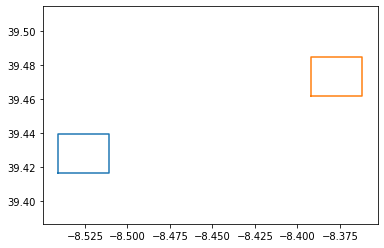

In [10]:
print(context+ filenames[0])
for file in filenames:
    cord = en.get_coords_from_cube(file[8:], return_meso=True)
    plt.plot([cord[0],cord[0],cord[2],cord[2],cord[0]], [cord[1],cord[3],cord[3],cord[1], cord[1]])
    #plt.plot([cord[4],cord[4],cord[6],cord[6],cord[4]], [cord[5],cord[7],cord[7],cord[5], cord[5]])
plt.axis('equal')
plt.show()

Here we look at some files inside the tile `29SND`

In [5]:
en.get_coords_from_tile("29SND")

(-9.0002, 38.754, -7.7187, 39.7503)

We now deep down in a single file. `ind` indicates which file we are using (in cardinal order) 

In [12]:
# single file
ind = 0
print(filenames[0])
sample = np.load(context + filenames[ind])
hrd = sample['highresdynamic']
md = sample["mesodynamic"]

# Accessing high-resolution and mesoscale static variables (the EUDEM digital elevation model)
hrs = sample["highresstatic"]
ms = sample["mesostatic"]

context_29SND_2017-06-20_2017-11-16_1977_2105_1721_1849_30_110_26_106.npz


Here we draw the satellite picture at the time `time` on the left. On the right we draw the elevation map. All of this is in the highres cubes. Furthermore, we print the coordinates of the supposed boundary of the highres area interested. However, checking on google earth, it seems that those locations are wrong.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


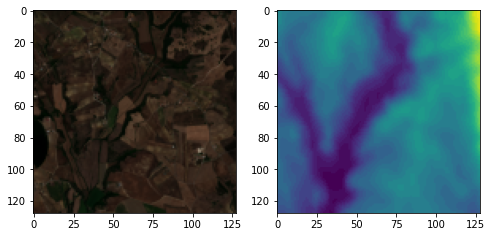

'\nprint("N: " + str(cord[3]))\nprint("S: " + str(cord[1]))\nprint("E: " + str(cord[2]))\nprint("W: " + str(cord[0]))'

In [17]:
time = 2
pic = np.flip(hrd[:,:,:3,time].astype(float),2) #Times 2 makes it lighter
fig, axs = plt.subplots(nrows=1,ncols = 2)
fig.set_size_inches(8,4)
axs[0].imshow(pic)
axs[1].imshow(hrs.astype(float))
#cord = en.get_coords_from_cube(filenames[ind], return_meso=True)
#print(str(cord[1]) +','+ str(cord[0]))
#print(str(cord[3]) +','+ str(cord[2]))
plt.show()
'''
print("N: " + str(cord[3]))
print("S: " + str(cord[1]))
print("E: " + str(cord[2]))
print("W: " + str(cord[0]))'''

In [19]:
def last_frame(cube, mask_channel = 4):
    # Note that by default the last channel will be the mask
    T = cube.shape[-1]
    
    mask = 1 - cube[:, mask_channel:mask_channel+1, :, :, T - 1] # 1 = good quality, 0 = bad quality (in the flipped version)   
    missing = cube[:, mask_channel:mask_channel+1, :, :, T - 1] #1 = is missing, 0 = is already assigned
    new_cube = cube[:, :4, :, :, T - 1] * mask

    t = T - 1
    while (torch.min(mask) == 0 and t >= 0):
        mask = missing * (1 - cube[:, mask_channel:mask_channel+1, :, :, t])
        new_cube += cube[:, :4, :, :, t] * mask
        missing = missing * (1 - mask)
        t -= 1
    return new_cube

In [20]:
cube = hrd[:,:,(0,1,2,3,6),:].astype(float)
cube = np.nan_to_num(cube[np.newaxis,...])
print(cube.shape)
last = last_frame(torch.Tensor(cube).permute(0,3,1,2,4))
print(last.shape)
img = np.array(last[0, (2,1,0), :,:].cpu())
plt.imshow(img.transpose(1,2,0)*2)

IndexError: index 6 is out of bounds for axis 2 with size 5

Here we look at the meso cubes. Here we are looking at the temperature on the left, and at an elevation map on the right in the meso scale. The small yellow square in the elevation map is the area to which the highres cubes refer to

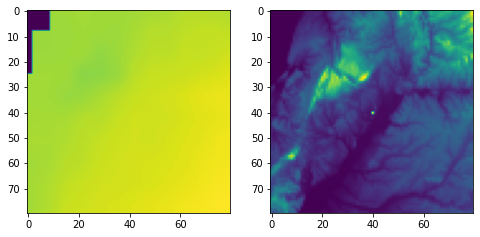

In [22]:
pic = md[:,:,2,20].astype(float) #Times 2 makes it lighter
pic2 = ms.astype(float)
pic2[40:41,40:41] = np.max(pic2)
#pic2[41,41] = np.max(pic2)
fig, axs = plt.subplots(nrows=1,ncols = 2)
fig.set_size_inches(8,4)
axs[0].imshow(pic)
axs[1].imshow(pic2)
#cord = en.get_coords_from_cube(filenames[ind], return_meso=True)
plt.show()